In [7]:
from detectron2.utils.logger import setup_logger

setup_logger()

from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

import os
import pickle
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2 import model_zoo

from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt



config_file_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

output_dir = "./output_yolo3/segmentation"
num_class = 4

device = "cuda"


test_dataset_name = "LP_test3"
test_images_path = r"C:\elicetrain\detectron2_custom_dataset\shuffled_images"
test_json_annot_path = r"C:\elicetrain\detectron2_custom_dataset\shuffled_labels_yolo_coco_bb.json"

cfg_svae_path = "IS_cfg_yolo.pikle"


if test_dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(test_dataset_name)
    MetadataCatalog.remove(test_dataset_name)


register_coco_instances(name=test_dataset_name, metadata={},
                        json_file=test_json_annot_path, image_root=test_images_path)


In [8]:
def evaluate_model(predictor, dataset):
    pixel_accuracies = []
    ious_per_class = [[] for _ in range(2)]  # 두 클래스: "parking space"와 "driveable space"
    aps_per_class = [[] for _ in range(2)]
    aps_50_per_class = [[] for _ in range(2)]  # IoU 0.5 이상에서의 AP

    for i, data in enumerate(dataset):
        img = cv2.imread(data["file_name"])  # 이미지 로드
        annotations = data["annotations"]
        true_class_ids = np.array([anno["category_id"] for anno in annotations])  # Ground truth class IDs

        # 모델 예측 수행
        outputs = predictor(img)
        pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()
        pred_class_ids = outputs["instances"].pred_classes.to("cpu").numpy()

        if len(pred_masks) > 0:
            pred_mask = pred_masks[0]  # 첫 번째 마스크 사용
        else:
            pred_mask = np.zeros((img.shape[0], img.shape[1]), dtype=bool)  # 빈 마스크 생성

        # 픽셀 정확도 계산 (여기서는 참고용, 실제 의미는 다를 수 있음)
        true_mask = np.zeros((img.shape[0], img.shape[1]), dtype=bool)
        pixel_accuracy = accuracy_score(true_mask.flatten(), pred_mask.flatten())
        pixel_accuracies.append(pixel_accuracy)

        # 각 클래스별로 IoU 및 AP 계산 ("parking space" = 0, "driveable space" = 1)
        for class_id, class_name in enumerate(["parking space", "driveable space"]):
            true_class_mask = (true_class_ids == class_id).astype(int)  # 이진 값으로 변환
            pred_class_mask = (pred_class_ids == class_id).astype(int)  # 이진 값으로 변환

            # 길이 확인 후 조정
            if len(true_class_mask) != len(pred_class_mask):
                min_len = min(len(true_class_mask), len(pred_class_mask))
                true_class_mask = true_class_mask[:min_len]
                pred_class_mask = pred_class_mask[:min_len]

            # IoU 계산
            if len(pred_class_mask) > 0 and np.sum(pred_class_mask) > 0:
                iou = jaccard_score(true_class_mask.flatten(), pred_class_mask.flatten(), average="binary")
                ious_per_class[class_id].append(iou)

                # IoU 0.5 이상일 때만 AP 계산
                if iou >= 0.5:
                    if np.sum(true_class_mask) > 0 and np.sum(pred_class_mask) > 0:
                        precision, recall, _ = precision_recall_curve(true_class_mask.flatten(), pred_class_mask.flatten(), pos_label=1)
                        if len(recall) > 0 and len(precision) > 0:
                            ap = auc(recall, precision)
                            aps_50_per_class[class_id].append(ap)

            # 모든 IoU에서 AP 계산
            if np.sum(true_class_mask) > 0 and np.sum(pred_class_mask) > 0:
                precision, recall, _ = precision_recall_curve(true_class_mask.flatten(), pred_class_mask.flatten(), pos_label=1)
                if len(recall) > 0 and len(precision) > 0:
                    ap = auc(recall, precision)
                    aps_per_class[class_id].append(ap)

    # 클래스별 IoU 및 AP 평균 계산
    mean_ious = [np.mean(iou_list) if len(iou_list) > 0 else 0 for iou_list in ious_per_class]
    mean_aps = [np.mean(ap_list) if len(ap_list) > 0 else 0 for ap_list in aps_per_class]
    mean_aps_50 = [np.mean(ap_list) if len(ap_list) > 0 else 0 for ap_list in aps_50_per_class]

    # mIoU 및 mAP 계산
    miou = np.mean(mean_ious)
    map_value = np.mean(mean_aps)
    map_50_value = np.mean(mean_aps_50)

    # 결과 출력
    print(f"Pixel Accuracy: {np.mean(pixel_accuracies)}")
    print(f"mIoU: {miou}")
    print(f"mAP: {map_value}")
    print(f"mAP@IoU 0.5: {map_50_value}")

    return {
        'pixel_accuracy': np.mean(pixel_accuracies),
        'class_iou': mean_ious,
        'class_ap': mean_aps,
        'class_ap_50': mean_aps_50,
        'miou': miou,
        'map': map_value,
        'map_50': map_50_value,
        'iou_per_class': ious_per_class,
        'aps_per_class': aps_per_class,
        'aps50_per_class': aps_50_per_class
    }


추론 및 후처리

[09/08 14:56:34 d2.data.datasets.coco]: Loading C:\elicetrain\detectron2_custom_dataset\shuffled_labels_yolo_coco_bb.json takes 2.97 seconds.
[09/08 14:56:34 d2.data.datasets.coco]: Loaded 14853 images in COCO format from C:\elicetrain\detectron2_custom_dataset\shuffled_labels_yolo_coco_bb.json
WARNING [09/08 14:56:35 d2.data.datasets.coco]: Filtered out 70 instances without valid segmentation. There might be issues in your dataset generation process.  Please check https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html carefully
Epoch 1/10
[09/08 14:56:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_0000001.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 14:56:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 14:56:36 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 14:56:37 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9333157724441814
mIoU: 0.23800020611205086
mAP: 0.38752191637891
mAP@IoU 0.5: 0.9230131630572198
Epoch 2/10
[09/08 15:57:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_0000002.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 15:57:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 15:57:08 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 15:57:08 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9232649564822192
mIoU: 0.27516542500528046
mAP: 0.4191316377527707
mAP@IoU 0.5: 0.9189288930513411
Epoch 3/10
[09/08 16:58:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_0000003.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 16:58:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 16:58:13 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 16:58:14 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9376778964523627
mIoU: 0.23011587246019743
mAP: 0.3736261743602732
mAP@IoU 0.5: 0.9163083518355815
Epoch 4/10
[09/08 17:59:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_0000004.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 17:59:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 17:59:52 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 17:59:52 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9492274927650024
mIoU: 0.21576409813172265
mAP: 0.3579509731629825
mAP@IoU 0.5: 0.9153226516644155
Epoch 5/10
[09/08 19:01:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_0000005.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 19:01:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 19:01:24 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 19:01:24 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.941830145625172
mIoU: 0.23795164506314948
mAP: 0.3864093911175299
mAP@IoU 0.5: 0.9172291049439674
Epoch 6/10
[09/08 20:02:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_0000006.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 20:02:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 20:02:25 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 20:02:25 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.935008264700339
mIoU: 0.24996363428874324
mAP: 0.39566710906663755
mAP@IoU 0.5: 0.9180000513112202
Epoch 7/10
[09/08 21:03:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_0000007.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 21:03:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 21:03:59 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 21:03:59 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9299807818589771
mIoU: 0.2760279008354336
mAP: 0.421530892170669
mAP@IoU 0.5: 0.9194206512076699
Epoch 8/10
[09/08 22:04:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_0000008.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 22:04:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 22:04:45 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 22:04:45 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9340986035901319
mIoU: 0.2581913356530213
mAP: 0.4000602450376288
mAP@IoU 0.5: 0.916632747467691
Epoch 9/10
[09/08 23:05:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_0000009.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 23:05:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 23:05:57 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 23:05:57 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9403381254218293
mIoU: 0.23169661110899126
mAP: 0.376102217682153
mAP@IoU 0.5: 0.9140207657629184
Epoch 10/10
[09/09 00:08:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_0000010.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/09 00:08:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/09 00:08:01 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/09 00:08:02 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9333191168837841
mIoU: 0.25207630619770427
mAP: 0.3954965477496245
mAP@IoU 0.5: 0.9197391769971779


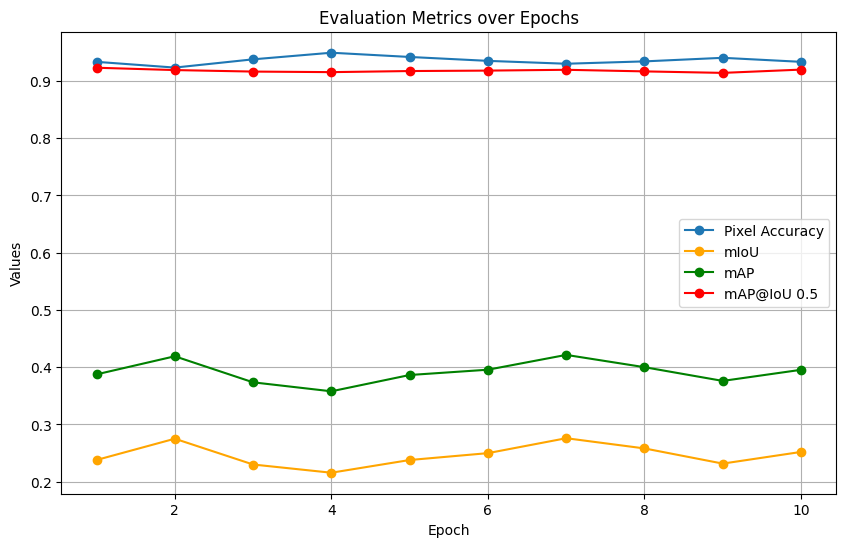

In [5]:
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
import numpy as np 
from sklearn.metrics import jaccard_score, precision_recall_curve, auc, accuracy_score
import torch
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling.roi_heads import FastRCNNOutputLayers, MaskRCNNConvUpsampleHead
from detectron2.modeling import build_model
import os

# 각 epoch마다 성능 지표를 저장할 리스트 초기화
pixel_accuracies = []
miou_values = []
map_values = []
map_50_values = []

# 설정
iterations_per_epoch = 4500
total_epochs = 10

# 기본적인 cfg 설정
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 클래스 수 설정
cfg.MODEL.DEVICE = "cuda"  # GPU 설정
dataset_val = DatasetCatalog.get(test_dataset_name)

# 10 epoch 동안 모델 평가
for epoch in range(total_epochs):
    print(f"Epoch {epoch + 1}/{total_epochs}")

    # 매 epoch마다 새로운 모델 가중치 파일을 지정 (여기서는 가중치 파일명에 epoch 숫자를 포함)
    weight_file = f"C:\\elicetrain\\detectron2_custom_dataset\\output_num4_batch16\\segmentation\\model_{(epoch+1):07d}.pth"
    
    if not os.path.exists(weight_file):
        print(f"가중치 파일 {weight_file}을 찾을 수 없습니다. 스킵합니다.")
        continue

    # 새로운 모델 객체 생성 및 가중치 로드
    model = build_model(cfg)  # 모델 빌드
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(weight_file)  # 가중치만 로드
    model.eval()  # **평가 모드로 전환**

    # 새로 로드한 모델로 predictor 생성
    predictor = DefaultPredictor(cfg)
    predictor.model = model  # 로드한 가중치를 포함한 모델 사용

    # 한 epoch이 끝난 후 evaluate_model() 함수 호출하여 평가
    results = evaluate_model(predictor, dataset_val)

    # 각 지표 저장
    pixel_accuracies.append(results['pixel_accuracy'])
    miou_values.append(results['miou'])
    map_values.append(results['map'])
    map_50_values.append(results['map_50'])

# 결과 시각화
epochs = range(1, total_epochs + 1)

# 하나의 그래프에 여러 지표 그리기
plt.figure(figsize=(10, 6))

# 각 지표를 하나의 그래프에 그리기
plt.plot(epochs, pixel_accuracies, label="Pixel Accuracy", marker='o')
plt.plot(epochs, miou_values, label="mIoU", marker='o', color='orange')
plt.plot(epochs, map_values, label="mAP", marker='o', color='green')
plt.plot(epochs, map_50_values, label="mAP@IoU 0.5", marker='o', color='red')

# 그래프 설정
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Evaluation Metrics over Epochs')
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()


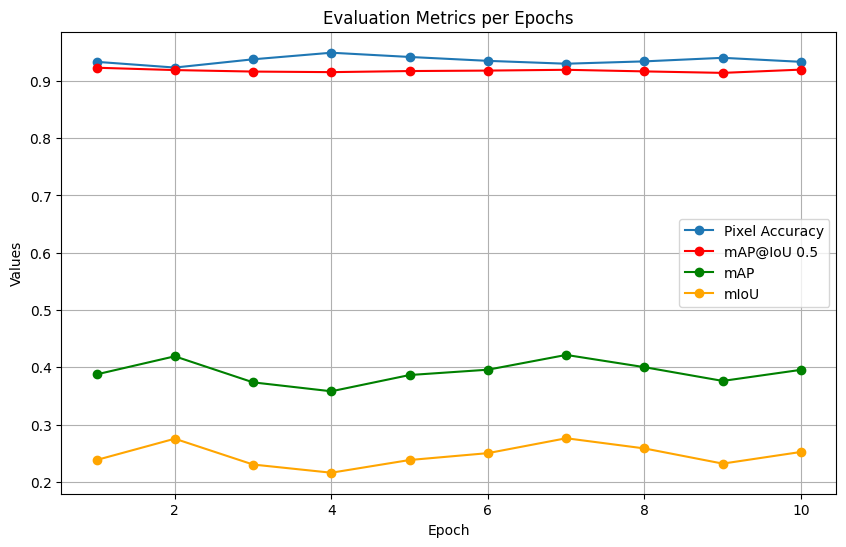

In [5]:
import matplotlib.pyplot as plt
epochs = range(1, 11)

pixel_accuracies =[0.9333, 0.9233, 0.9377, 0.9492, 0.9418, 0.9350, 0.9300, 0.9341, 0.9403, 0.9333]
map_50_values =[0.9230, 0.9189, 0.9163, 0.9153, 0.9172, 0.9180, 0.9194, 0.9166, 0.9140, 0.9197]
map_values =[0.3875, 0.4191, 0.3736, 0.3580, 0.3864, 0.3957, 0.4215, 0.4001, 0.3761, 0.3955]
miou_values =[0.2380, 0.2752, 0.2301, 0.2158, 0.2380, 0.2500, 0.2760, 0.2582, 0.2317, 0.2521]


# 하나의 그래프에 여러 지표 그리기
plt.figure(figsize=(10, 6))

# 각 지표를 하나의 그래프에 그리기
plt.plot(epochs, pixel_accuracies, label="Pixel Accuracy", marker='o')
plt.plot(epochs, map_50_values, label="mAP@IoU 0.5", marker='o', color='red')
plt.plot(epochs, map_values, label="mAP", marker='o', color='green')
plt.plot(epochs, miou_values, label="mIoU", marker='o', color='orange')



# 그래프 설정
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Evaluation Metrics per Epochs')
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()


In [16]:
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
import numpy as np 
from sklearn.metrics import jaccard_score, precision_recall_curve, auc, accuracy_score
import torch
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling.roi_heads import FastRCNNOutputLayers, MaskRCNNConvUpsampleHead
from detectron2.modeling import build_model
import os


cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

cfg.MODEL.WEIGHTS = r"C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_final.pth"


# 예측에 사용할 score threshold 설정
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

# 데이터셋의 클래스 수에 맞게 설정 (훈련 시 사용한 설정과 동일해야 함)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 예: 80 classes in COCO

# GPU가 여러 개라면 이를 설정 (기본적으로는 1)
cfg.MODEL.DEVICE = "cuda"  # 또는 "cpu"

predictor = DefaultPredictor(cfg)


[09/09 10:14:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_final.pth ...


[32m[09/09 10:14:33 d2.checkpoint.detection_checkpoint]: [0m[DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_final.pth ...


In [ ]:
dataset_val = DatasetCatalog.get(test_dataset_name)  # Validation dataset을 가져옵니다.
results10 = evaluate_model(predictor, dataset_val)